# Random Forest Implementation

## Set Up

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import helpers as hp
import models.randomforest as rf
import models.lstm as lstm


In [2]:
# recent https://forecast.weather.gov/product.php?site=MFL&issuedby=MIA&product=CLI&format=CI&version=2&glossary=0
# Old https://climatecenter.fsu.edu/climate-data-access-tools/downloadable-data


df = pd.read_csv("True values/miami_weather_complete.csv")
df['Datetime'] = pd.to_datetime(df['Datetime'])

In [3]:
df = df.drop(columns = {"Unnamed: 0", "precipitation",	"mean temp"})
df

,actual_max_temp,min temp,Datetime
0,81.0,63.0,2000-01-01
1,79.0,66.0,2000-01-02
2,80.0,64.0,2000-01-03
3,80.0,71.0,2000-01-04
4,80.0,67.0,2000-01-05
...,...,...,...
9089,72.0,55.0,2024-11-23
9090,78.0,58.0,2024-11-24
9091,82.0,64.0,2024-11-25
9092,84.0,67.0,2024-11-26


In [4]:
openmeteo = pd.read_csv('Open Meteo forecast/MiamiOpenMeteoData.csv')

In [5]:
openmeteo['time'] = pd.to_datetime(openmeteo['time'], format='%m/%d/%y')

# Convert the datetime column back to the desired string format 'DD/MM/YYYY'
openmeteo['time'] = openmeteo['time'].dt.strftime('%m-%d-%Y')

openmeteo = openmeteo.rename(columns = {"time": "Datetime"})
openmeteo['Datetime'] = pd.to_datetime(openmeteo['Datetime'])
openmeteo.dtypes

Datetime                           datetime64[ns]
weather_code (wmo code)                     int64
temperature_2m_max (°F)                   float64
temperature_2m_min (°F)                   float64
temperature_2m_mean (°F)                  float64
apparent_temperature_max (°F)             float64
apparent_temperature_min (°F)             float64
apparent_temperature_mean (°F)            float64
sunrise (iso8601)                          object
sunset (iso8601)                           object
daylight_duration (s)                     float64
sunshine_duration (s)                     float64
precipitation_sum (mm)                    float64
rain_sum (mm)                             float64
snowfall_sum (cm)                         float64
precipitation_hours (h)                     int64
wind_speed_10m_max (mp/h)                 float64
wind_gusts_10m_max (mp/h)                 float64
wind_direction_10m_dominant (°)           float64
shortwave_radiation_sum (MJ/m²)           float64


In [6]:
newdf = pd.merge(df,openmeteo, how = "inner", on = "Datetime")

In [7]:
newdf = newdf.drop(columns = {'sunrise (iso8601)','sunset (iso8601)', 'weather_code (wmo code)'})

In [8]:
newdf['precipitation_hours (h)'] = newdf['precipitation_hours (h)'].astype(float)
newdf = newdf.set_index("Datetime")

In [9]:
for col in newdf.columns:
            for lag in range(1,7):
                newdf[f'{col}_lag{lag}'] = newdf[col].shift(lag)
newdf = newdf.dropna()
new_lstm_df = newdf.copy()

/var/folders/mg/jjtr9hhj5zj6g0svf83l817h0000gn/T/ipykernel_61045/2430413464.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  newdf[f'{col}_lag{lag}'] = newdf[col].shift(lag)
/var/folders/mg/jjtr9hhj5zj6g0svf83l817h0000gn/T/ipykernel_61045/2430413464.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  newdf[f'{col}_lag{lag}'] = newdf[col].shift(lag)
/var/folders/mg/jjtr9hhj5zj6g0svf83l817h0000gn/T/ipykernel_61045/2430413464.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.

In [54]:
newdf.columns

Index(['actual_max_temp', 'min temp', 'temperature_2m_max (°F)',
       'temperature_2m_min (°F)', 'temperature_2m_mean (°F)',
       'apparent_temperature_max (°F)', 'apparent_temperature_min (°F)',
       'apparent_temperature_mean (°F)', 'daylight_duration (s)',
       'sunshine_duration (s)',
       ...
       'shortwave_radiation_sum (MJ/m²)_lag3',
       'shortwave_radiation_sum (MJ/m²)_lag4',
       'shortwave_radiation_sum (MJ/m²)_lag5',
       'shortwave_radiation_sum (MJ/m²)_lag6',
       'et0_fao_evapotranspiration (mm)_lag1',
       'et0_fao_evapotranspiration (mm)_lag2',
       'et0_fao_evapotranspiration (mm)_lag3',
       'et0_fao_evapotranspiration (mm)_lag4',
       'et0_fao_evapotranspiration (mm)_lag5',
       'et0_fao_evapotranspiration (mm)_lag6'],
      dtype='object', length=133)

## Create training sets

In [57]:
feature_columns = [
        'daylight_duration (s)', 'wind_gusts_10m_max (mp/h)',
        'wind_speed_10m_max (mp/h)',
        'actual_max_temp_lag1',
       'min temp_lag1', 'temperature_2m_max (°F)_lag1',
       'temperature_2m_min (°F)_lag1', 'temperature_2m_mean (°F)_lag1',
        'daylight_duration (s)_lag1',
       'sunshine_duration (s)_lag1', 'precipitation_sum (mm)_lag1',
       'rain_sum (mm)_lag1', 
       'precipitation_hours (h)_lag1', 'wind_speed_10m_max (mp/h)_lag1',
       'wind_gusts_10m_max (mp/h)_lag1',
       'wind_direction_10m_dominant (°)_lag1',
       'shortwave_radiation_sum (MJ/m²)_lag1',
       'et0_fao_evapotranspiration (mm)_lag1'
]

target = 'actual_max_temp'


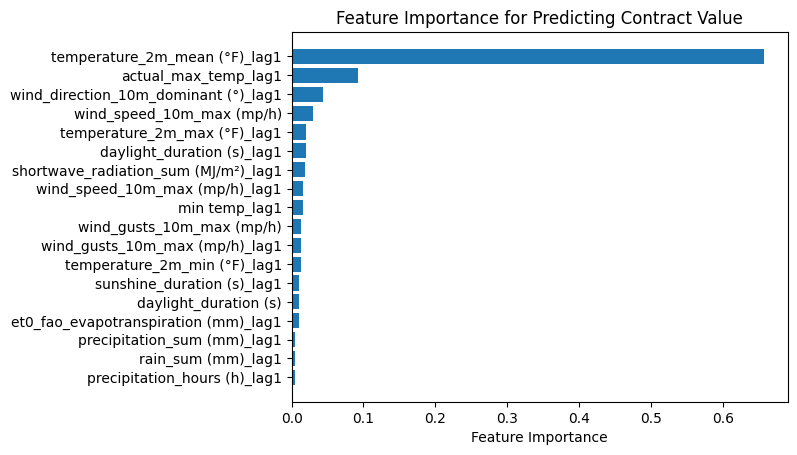

,Feature,Importance
7,temperature_2m_mean (°F)_lag1,0.657110
3,actual_max_temp_lag1,0.093056
15,wind_direction_10m_dominant (°)_lag1,0.044267
2,wind_speed_10m_max (mp/h),0.029639
5,temperature_2m_max (°F)_lag1,0.020109
8,daylight_duration (s)_lag1,0.019431
16,shortwave_radiation_sum (MJ/m²)_lag1,0.018480
13,wind_speed_10m_max (mp/h)_lag1,0.016433
4,min temp_lag1,0.015824
1,wind_gusts_10m_max (mp/h),0.013396


In [58]:

rf.find_important_features(newdf, feature_columns, target)

## Testing the performance of the Random Forest model

In [12]:
X = newdf[feature_columns]
y = newdf[target]


X_train, y_train, X_test, y_test = hp.create_train_test(X, y, .8)
all_predictions = pd.DataFrame()

In [13]:
# grid search
best_model = rf.find_best_random_forest_model(X_train, y_train)

# get predictions
predictions = rf.get_rf_predictions(best_model, X_test)

# Calculate errors
hp.calculate_metrics(y_test, predictions)

Best parameters found:  {'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation score:  0.8124198947583373
Mean Squared Error (MSE): 7.846270888803734
Mean Absolute Error (MAE): 2.075813133303279
Root Mean Squared Error (RMSE): 2.801119577740967


(7.846270888803734, 2.801119577740967, 2.075813133303279)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
91/91 - 5s - 51ms/step - accuracy: 0.0000e+00 - loss: 0.6145 - val_accuracy: 0.0000e+00 - val_loss: 0.3258
Epoch 2/50
91/91 - 1s - 11ms/step - accuracy: 0.0000e+00 - loss: 0.3478 - val_accuracy: 0.0000e+00 - val_loss: 0.2820
Epoch 3/50
91/91 - 1s - 10ms/step - accuracy: 0.0000e+00 - loss: 0.3150 - val_accuracy: 0.0000e+00 - val_loss: 0.2559
Epoch 4/50
91/91 - 1s - 11ms/step - accuracy: 0.0000e+00 - loss: 0.2836 - val_accuracy: 0.0000e+00 - val_loss: 0.2451
Epoch 5/50
91/91 - 1s - 11ms/step - accuracy: 0.0000e+00 - loss: 0.2705 - val_accuracy: 0.0000e+00 - val_loss: 0.2349
Epoch 6/50
91/91 - 1s - 11ms/step - accuracy: 0.0000e+00 - loss: 0.2592 - val_accuracy: 0.0000e+00 - val_loss: 0.2290
Epoch 7/50
91/91 - 1s - 11ms/step - accuracy: 0.0000e+00 - loss: 0.2519 - val_accuracy: 0.0000e+00 - val_loss: 0.2209
Epoch 8/50
91/91 - 1s - 11ms/step - accuracy: 0.0000e+00 - loss: 0.2514 - val_accuracy: 0.0000e+00 - val_loss: 0.2189
Epoch 9/50
91/91 - 1s - 10ms/step - accuracy: 0.0000e+00

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 7, 60)          │        11,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 7, 40)          │        12,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 20)             │         4,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,613 (369.59 KB)

 Trainable params: 31,537 (123.19 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 63,076 (246.39 KB)

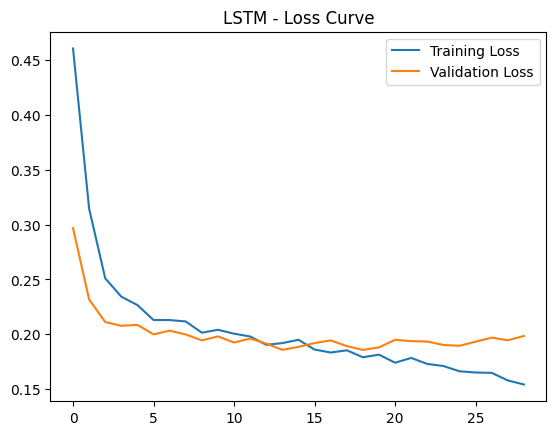

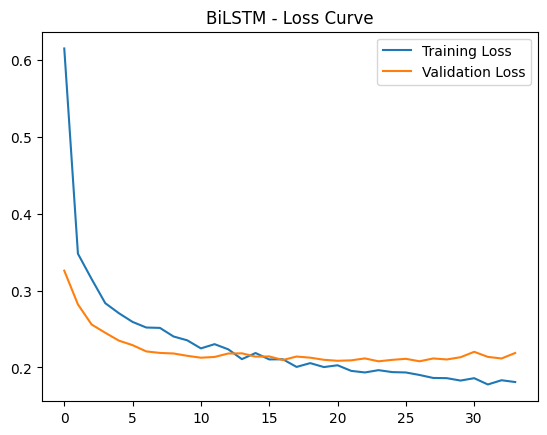

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout, Embedding, LSTM, Bidirectional

# def prepare_data(X_train, y_train, X_test, y_test, window_size=12):
#     feature_scaler = StandardScaler()
#     X_np_train = X_train.values
#     X_scaled_train = feature_scaler.fit_transform(X_np_train)
    
#     target_scaler = StandardScaler()
#     y_np_train = y_train.values
#     y_scaled_train = target_scaler.fit_transform(y_np_train.reshape(-1, 1))
    

y_lstm = new_lstm_df['actual_max_temp']

X_lstm = new_lstm_df[['temperature_2m_mean (°F)_lag1',
 'apparent_temperature_mean (°F)_lag1',
 'apparent_temperature_min (°F)_lag1',
 'apparent_temperature_max (°F)_lag1',
 'actual_max_temp_lag1',
 'wind_direction_10m_dominant (°)_lag1',
 'temperature_2m_max (°F)_lag1']]
 
window = 7
X_windowed, y_windowed, X_test_windowed, y_test_windowed, feature_scaler, target_scaler = lstm.prepare_data(X_train, y_train, X_test, y_test, window_size=window)

lstm_units = 64  
lstm_batch_size = 64
lstm_epochs = 50
lstm_history, LSTM_model_name, trained_lstm_model = lstm.train_LSTM(X_windowed, y_windowed, lstm_units, lstm_batch_size, lstm_epochs, verbose=2, learning_rate = .0007)

bl_units = 64  
bl_batch_size = 64
bl_epochs = 50
bilstm_history, biLSTM_model_name, trained_bilstm_model = lstm.train_BiLSTM(X_windowed, y_windowed, bl_units, bl_batch_size, bl_epochs, verbose=2, learning_rate = .0005)

# Model summary to check the architecture
trained_bilstm_model.summary()



# Plot loss curves
lstm.plot_loss(lstm_history, LSTM_model_name)
lstm.plot_loss(bilstm_history, biLSTM_model_name)

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


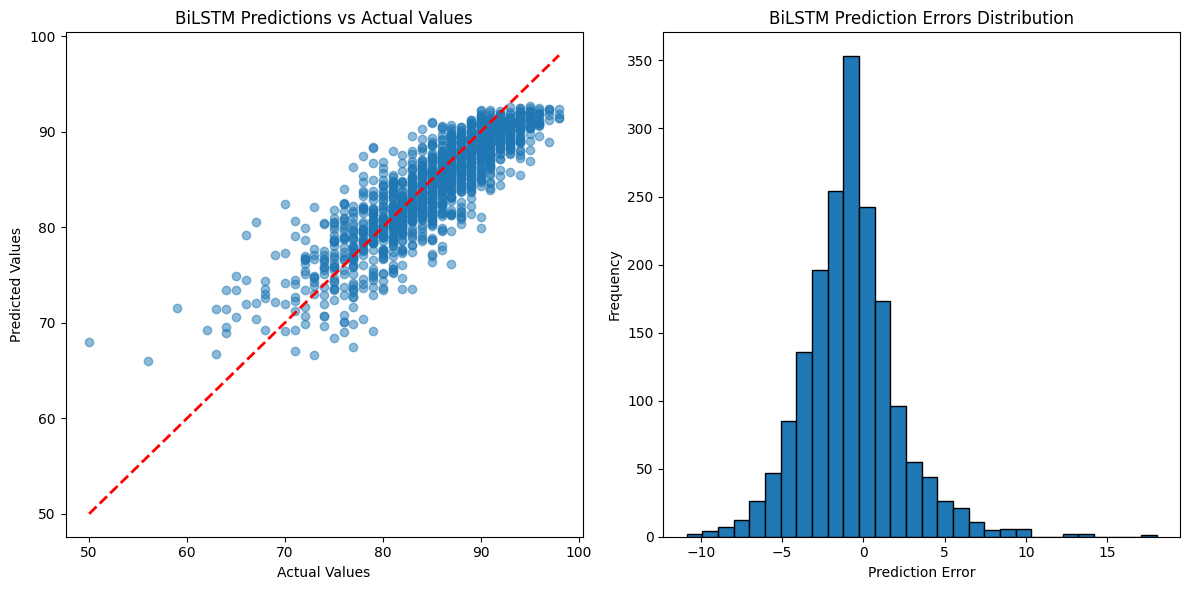

Mean Squared Error (MSE): 8.980999724328317
Mean Absolute Error (MAE): 2.246115396091217
Root Mean Squared Error (RMSE): 2.9968316142767044


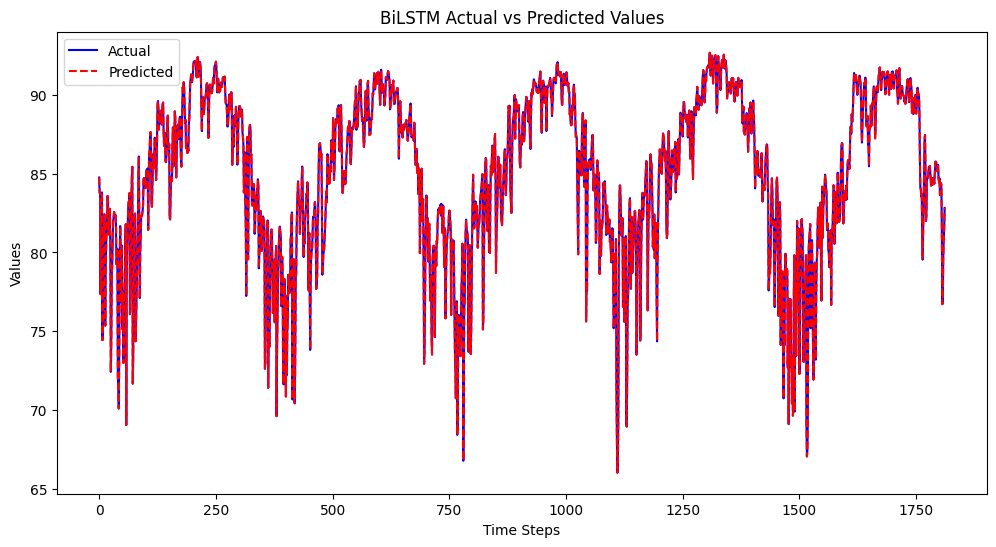

In [16]:
bilstm_y_pred = lstm.get_predictions(trained_bilstm_model, X_test_windowed)

lstm.plot_predictions(biLSTM_model_name, X_test_windowed, y_test_windowed, bilstm_y_pred, target_scaler)

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


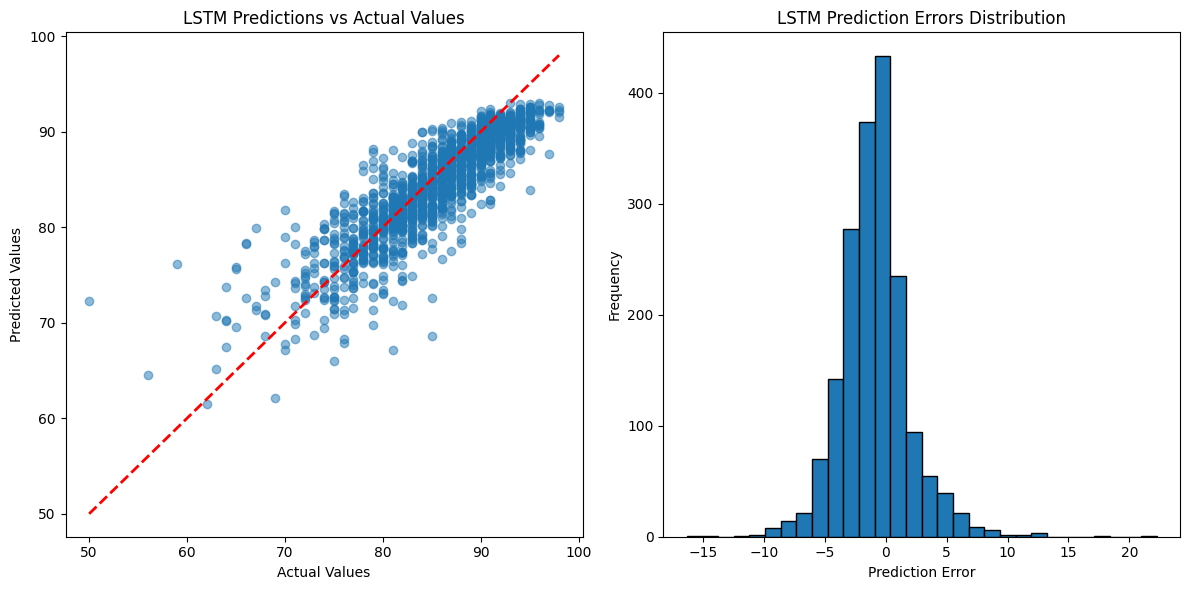

Mean Squared Error (MSE): 9.22744936904623
Mean Absolute Error (MAE): 2.2364530163358642
Root Mean Squared Error (RMSE): 3.037671701985952


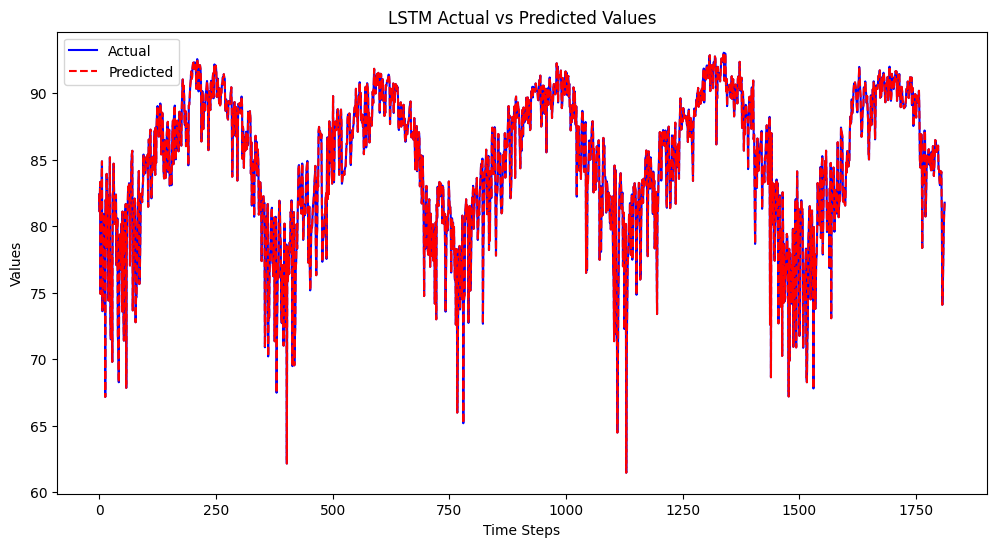

In [17]:
lstm_y_pred = lstm.get_predictions(trained_lstm_model, X_test_windowed)
lstm.plot_predictions(LSTM_model_name, X_test_windowed, y_test_windowed, lstm_y_pred, target_scaler)

In [ ]:

missing = window - 1

y_actual_test = y_test.iloc[missing:] #removes the first two observations since those are removed in the sliding window process.
rf_predictions = predictions[missing:]
predictions_df = pd.DataFrame(y_actual_test)
predictions_df['lstm_predictions'] = lstm_y_pred
predictions_df['bilstm_predictions'] = bilstm_y_pred
predictions_df['rf_predictions'] = rf_predictions

open_meteo_forecast = pd.read_csv("/Users/bram/Desktop/AI-class/semester-project-bram-long/open-meteo-25.79N80.28W2m.csv")
open_meteo_forecast ['time'] = pd.to_datetime(open_meteo_forecast ['time'], format='%m/%d/%y')
open_meteo_forecast = open_meteo_forecast.set_index("time")


prediction_merge = pd.merge(open_meteo_forecast, predictions_df, left_index=True, right_index=True)
prediction_merge





,open_meteo_forecast,actual_max_temp,lstm_predictions,bilstm_predictions,rf_predictions
2022-01-01,80.5,82.0,-0.502927,-0.298057,80.739328
2022-01-02,81.8,83.0,-0.474302,-0.388456,81.829026
2022-01-03,80.5,81.0,-0.585255,-0.475659,80.435504
2022-01-04,77.3,78.0,-1.248770,-1.323943,76.914714
2022-01-05,78.6,81.0,-0.609633,-0.652366,79.645027
...,...,...,...,...,...
2024-11-23,70.7,72.0,-1.498294,-1.211927,74.031774
2024-11-24,77.3,78.0,-1.131926,-0.779327,75.291611
2024-11-25,80.0,82.0,-0.755005,-0.586714,79.101081
2024-11-26,81.8,84.0,-0.547581,-0.484396,80.790892


In [25]:
actual = prediction_merge['actual_max_temp']
open_predicted = prediction_merge['open_meteo_forecast']

hp.calculate_metrics(actual , open_predicted)

Mean Squared Error (MSE): 4.49751178133836
Mean Absolute Error (MAE): 1.7532516493873702
Root Mean Squared Error (RMSE): 2.120733783702792


(4.49751178133836, 2.120733783702792, 1.7532516493873702)

In [42]:
y_ensemble = prediction_merge['actual_max_temp']

X_ensemble = prediction_merge[['open_meteo_forecast', 'lstm_predictions',
       'bilstm_predictions', 'rf_predictions']]
 
X_ensemble_train, X_ensemble_test, y_ensemble_train, y_ensemble_test = hp.create_train_test(X_ensemble ,y_ensemble, .6)

ensemble_X_windowed, ensemble_y_windowed, ensemble_X_test_windowed, ensemble_y_test_windowed, ensemble_feature_scaler, ensemble_target_scaler = lstm.prepare_data(X_ensemble_train, X_ensemble_test, y_ensemble_train, y_ensemble_test, window_size=7)

lstm_units = 64  
lstm_batch_size = 64
lstm_epochs = 50
ensemble_lstm_history, ensemble_LSTM_model_name, ensemble_trained_lstm_model = lstm.train_LSTM(ensemble_X_windowed, ensemble_y_windowed, lstm_units, lstm_batch_size, lstm_epochs, verbose=2, learning_rate = .0007)

bl_units = 64  
bl_batch_size = 64
bl_epochs = 50
ensemble_bilstm_history, ensemble_biLSTM_model_name, ensemble_trained_bilstm_model = lstm.train_BiLSTM(ensemble_X_windowed, ensemble_y_windowed, bl_units, bl_batch_size, bl_epochs, verbose=2, learning_rate = .0005)



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
8/8 - 4s - 473ms/step - accuracy: 0.0000e+00 - loss: 0.8836 - val_accuracy: 0.0000e+00 - val_loss: 1.0767
Epoch 2/50
8/8 - 0s - 9ms/step - accuracy: 0.0000e+00 - loss: 0.7981 - val_accuracy: 0.0000e+00 - val_loss: 1.0380
Epoch 3/50
8/8 - 0s - 9ms/step - accuracy: 0.0000e+00 - loss: 0.6727 - val_accuracy: 0.0000e+00 - val_loss: 0.9906
Epoch 4/50
8/8 - 0s - 9ms/step - accuracy: 0.0000e+00 - loss: 0.6118 - val_accuracy: 0.0000e+00 - val_loss: 0.9309
Epoch 5/50
8/8 - 0s - 9ms/step - accuracy: 0.0000e+00 - loss: 0.5711 - val_accuracy: 0.0000e+00 - val_loss: 0.8628
Epoch 6/50
8/8 - 0s - 9ms/step - accuracy: 0.0000e+00 - loss: 0.5376 - val_accuracy: 0.0000e+00 - val_loss: 0.7944
Epoch 7/50
8/8 - 0s - 9ms/step - accuracy: 0.0000e+00 - loss: 0.5144 - val_accuracy: 0.0000e+00 - val_loss: 0.7206
Epoch 8/50
8/8 - 0s - 9ms/step - accuracy: 0.0000e+00 - loss: 0.4658 - val_accuracy: 0.0000e+00 - val_loss: 0.6417
Epoch 9/50
8/8 - 0s - 9ms/step - accuracy: 0.0000e+00 - loss: 0.4435 - val_acc

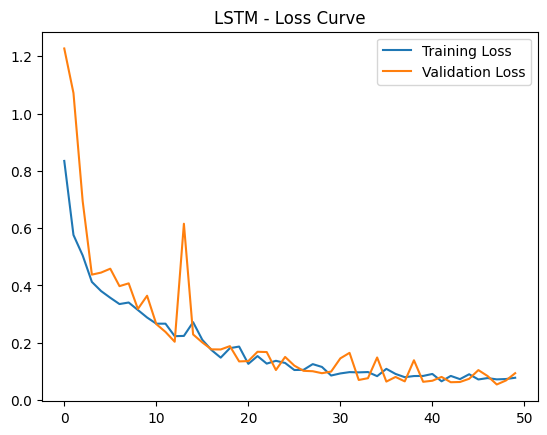

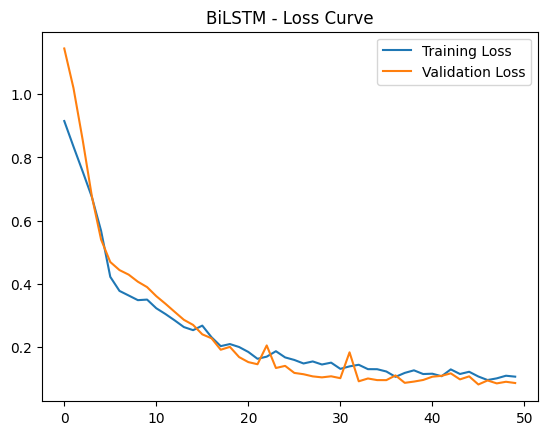

In [39]:

lstm.plot_loss(ensemble_lstm_history, ensemble_LSTM_model_name)
lstm.plot_loss(ensemble_bilstm_history, ensemble_biLSTM_model_name)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


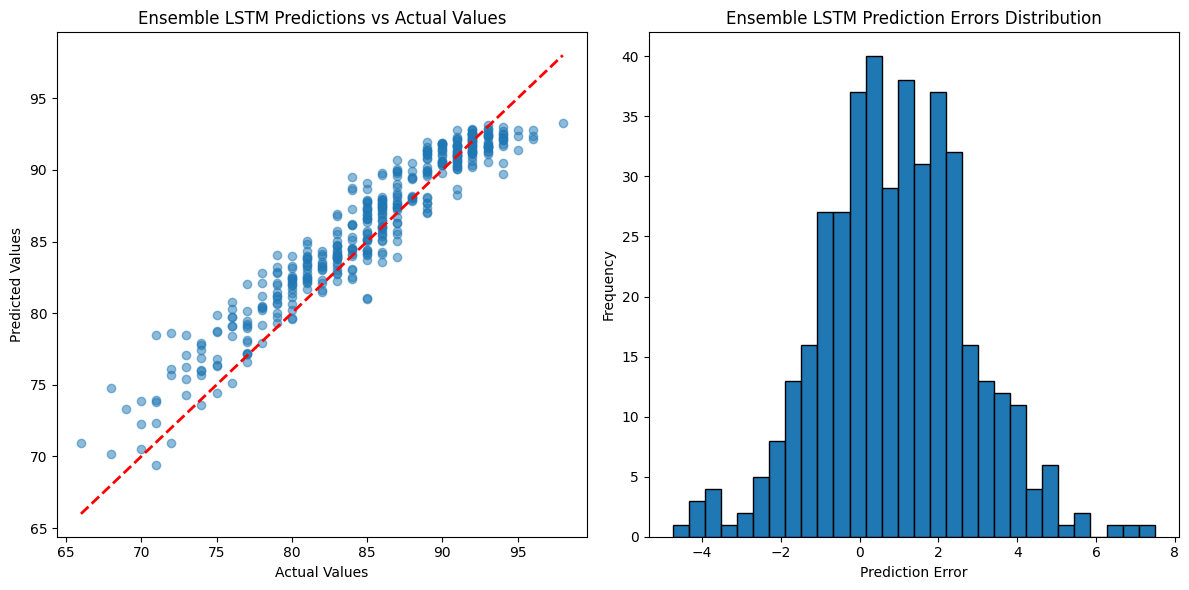

Mean Squared Error (MSE): 4.38677800691082
Mean Absolute Error (MAE): 1.64346258850826
Root Mean Squared Error (RMSE): 2.0944636561446512


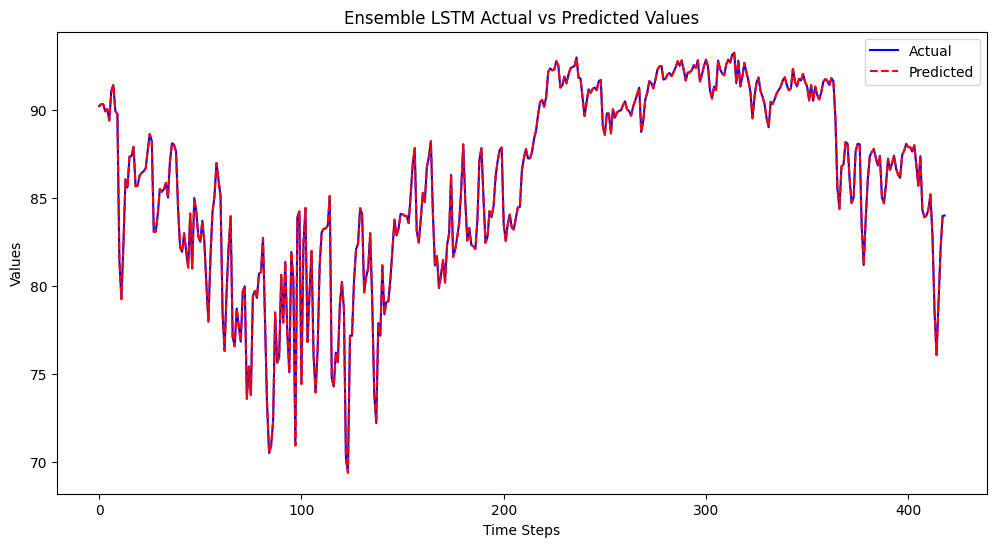

In [43]:
ensemble_lstm_y_pred = lstm.get_predictions(ensemble_trained_lstm_model, ensemble_X_test_windowed)

lstm.plot_predictions('Ensemble LSTM', ensemble_X_test_windowed, ensemble_y_test_windowed, ensemble_lstm_y_pred, ensemble_target_scaler)

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


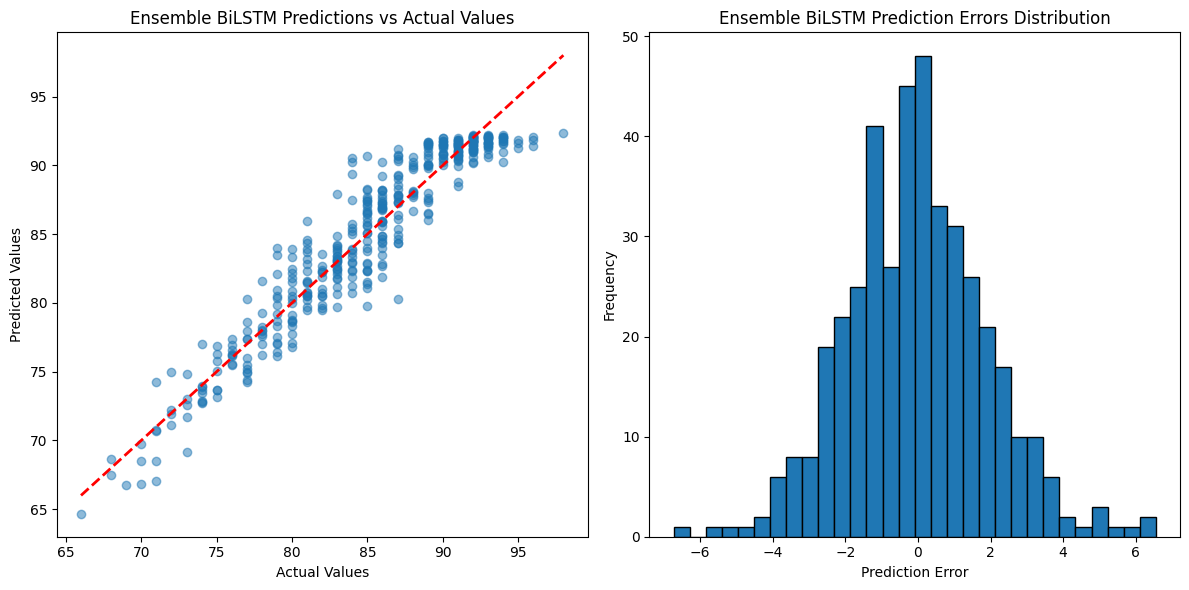

Mean Squared Error (MSE): 3.7428258460464883
Mean Absolute Error (MAE): 1.489979400270594
Root Mean Squared Error (RMSE): 1.9346384277291941


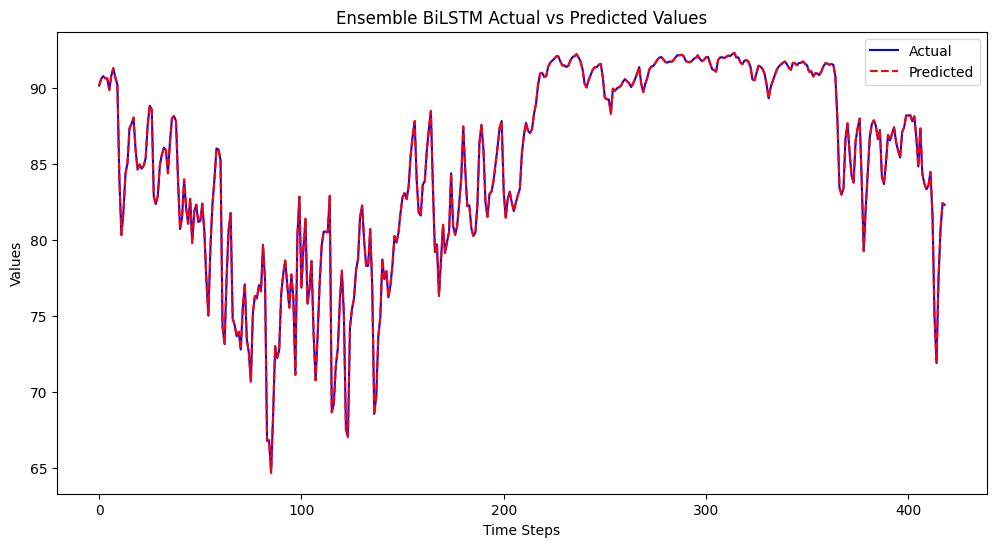

In [44]:
ensemble_bilstm_y_pred = lstm.get_predictions(ensemble_trained_bilstm_model, ensemble_X_test_windowed)

lstm.plot_predictions('Ensemble BiLSTM', ensemble_X_test_windowed, ensemble_y_test_windowed, ensemble_bilstm_y_pred, ensemble_target_scaler)

In [ ]:
import shap
tf.compat.v1.disable_eager_execution()


explainer = shap.DeepExplainer(ensemble_trained_bilstm_model, ensemble_X_windowed)

# Now you can get SHAP values for a batch of inputs
shap_values = explainer.shap_values(ensemble_X_windowed[:10])


# ensemble_trained_bilstm_model.input_shape